# Predict Customer Clicked Ads Classification by Using Machine Learning

## Customer Type and Behaviour Analysis on Advertisement

### Requirements

In [1]:
# You need to install library ppscore to calculate correlation between variable
!pip install -U ppscore

### Import Library

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from collections import defaultdict
import ppscore as pps

from warnings import filterwarnings
filterwarnings('ignore')

### Create UDFs

In [3]:
## UDF for Feature Extraction
def extract_day_of_week(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').weekday()

def extract_day_of_month(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').day

def extract_month(time):
    return dt.strptime(time,'%m/%d/%Y %H:%M').month


In [4]:
## UDF for experimenting several classification models
def experiment(X_train,X_test,y_train,y_test):
    """
    This function want to do an experiment for several models.
    We just need data input

    Parameter
    ---------
    X_train = training data contains several features
    X_test = testing data contains several features
    y_train = train target
    y_test = test target
    """
    result = defaultdict(list)
    
    knn = KNeighborsClassifier()
    logreg = LogisticRegression()
    dtc = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    grad = GradientBoostingClassifier()
    
    list_model = [('K-Nearest Neighbor',knn),
                  ('Logistic Regression',logreg),
                  ('Decision Tree',dtc),
                  ('Random Forest',rf),
                  ('Gradient Boosting',grad)
                 ]
    
    for model_name,model in list_model:
        start = dt.now()
        model.fit(X_train,y_train)
        duration = (dt.now()-start).total_seconds()
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred)
        
        result['model_name'].append(model_name)
        result['model'].append(model)
        result['accuracy'].append(accuracy)
        result['recall'].append(recall)
        result['precision'].append(precision)
        result['duration'].append(duration)
        
    return result

### Import Dataset

Before we do the analysis, we need to prepare the data first. At this stage, we will call the data into the jupyter notebook and take a glimpse of what the data looks like.

In [5]:
df = pd.read_csv('C:/Users/62812/OneDrive/Documents/Fadil/Data Science/Mini Project/MP 4/Asli/Clicked Ads Dataset.csv')
df.head()

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


### Data Types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 78.2+ KB


### Statistics Descriptive

In [8]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
count,987.000000,1000.000000,9.870000e+02,989.000000
mean,64.929524,36.009000,3.848647e+08,179.863620
std,15.844699,8.785562,9.407999e+07,43.870142
min,32.600000,19.000000,9.797550e+07,104.780000
25%,51.270000,29.000000,3.286330e+08,138.710000
50%,68.110000,35.000000,3.990683e+08,182.650000
75%,78.460000,42.000000,4.583554e+08,218.790000
max,91.430000,61.000000,5.563936e+08,267.010000


In [9]:
df.select_dtypes('object').describe()

,Male,Timestamp,Clicked on Ad,city,province,category
count,997,1000,1000,1000,1000,1000
unique,2,997,2,30,16,10
top,Perempuan,5/26/2016 15:40,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif
freq,518,2,500,64,253,112


### Exploratory Data Analysis

### Clicked on Ad Distribution

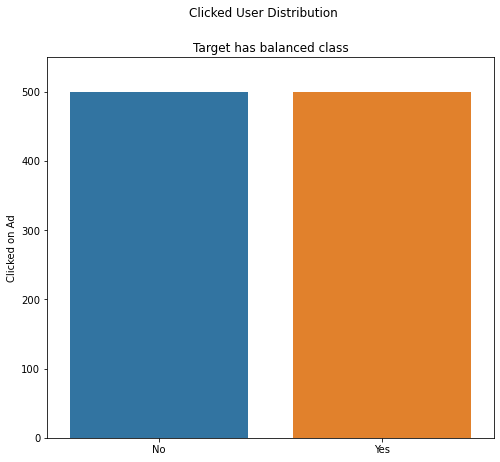

In [10]:
counts = df['Clicked on Ad'].value_counts()

plt.figure(figsize=(8,7))

sns.barplot(x=counts.index,y=counts)

plt.suptitle('Clicked User Distribution')
plt.title('Target has balanced class')
plt.ylim(0,550)
plt.show()

The data we will use turns out to have enough balanced labels that we don't need to do preprocessing to overcome the imbalanced class.

### Daily Internet Usage

In [11]:
yes = df[df['Clicked on Ad'] == 'Yes']
no = df[df['Clicked on Ad'] == 'No']

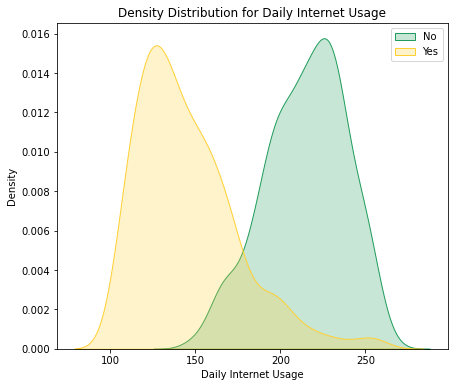

In [12]:
plt.figure(figsize=(7,6))

sns.kdeplot(no['Daily Internet Usage'],label='No', color='#209D5C', fill=True)
sns.kdeplot(yes['Daily Internet Usage'],label='Yes', color='#FFD034', fill=True)

plt.title('Density Distribution for Daily Internet Usage')
plt.legend()
plt.show()

From the EDA above, we can see the distribution of daily internet usage (in minutes). There is something interesting in the following distribution. That the potential for users to click on a product is higher for users who rarely use the internet than those who often use the internet. 

This could indicate that users who rarely use the internet tend to pay more attention to advertisements on a website.

### Daily Time Spent on Site

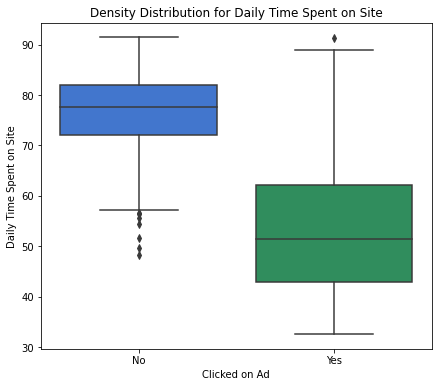

In [13]:
plt.figure(figsize=(7,6))

colors = ["#2B70E4", "#209D5C"]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.boxplot(x=df['Clicked on Ad'],y=df['Daily Time Spent on Site'], palette=customPalette)

plt.title('Density Distribution for Daily Time Spent on Site')
plt.show()

Because internet usage has a distinct distribution. We want to demonstrate how a person's behavior on a website. Based on the EDA, it appears that internet usage and user duration on a website have a similar distribution. That is, potential users can be located even when only briefly browsing a website.

### Age

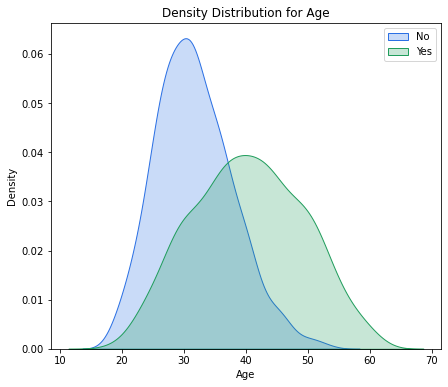

In [14]:
plt.figure(figsize=(7,6))

sns.kdeplot(no['Age'],label='No',color='#2B70E4', fill=True)
sns.kdeplot(yes['Age'],label='Yes', color='#209D5C', fill=True)

plt.title('Density Distribution for Age')
plt.legend()
plt.show()

According to the visualization of age, the potential market is actually found among older adults. Perhaps because young people are more cautious and picky while using the internet. And young people are quite aware when adverts appear on a website.

### Internet Usage vs Time Spent on Site

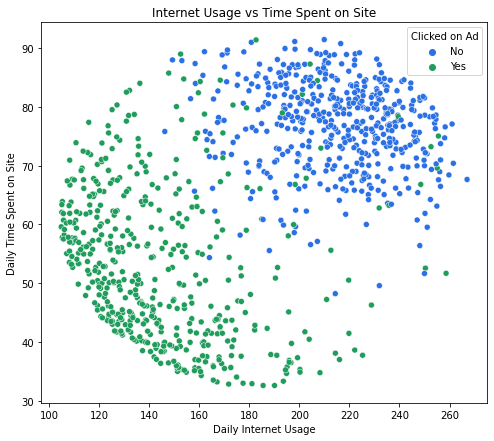

In [15]:
plt.figure(figsize=(8,7))

colors = ["#2B70E4", "#209D5C"]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x=df['Daily Internet Usage'],y=df['Daily Time Spent on Site'],hue=df['Clicked on Ad'], palette=customPalette)

plt.title('Internet Usage vs Time Spent on Site')
plt.show()

After recognizing the relationship between internet consumption and the length of a website visit. We try to figure out what the connection is between these two traits and their goals.

According to the plot, internet usage and the length of a site visit can be separated into two groups: active users and non-active users.

These two segments can be a feature that is quite close to whether or not someone will click on an ad. The visualization above shows that active users are less likely than non-active users to click on an ad.

Finally, we can tailor our advertising system to consumers who are not actively utilizing the internet.

In [16]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [17]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


### Correlation

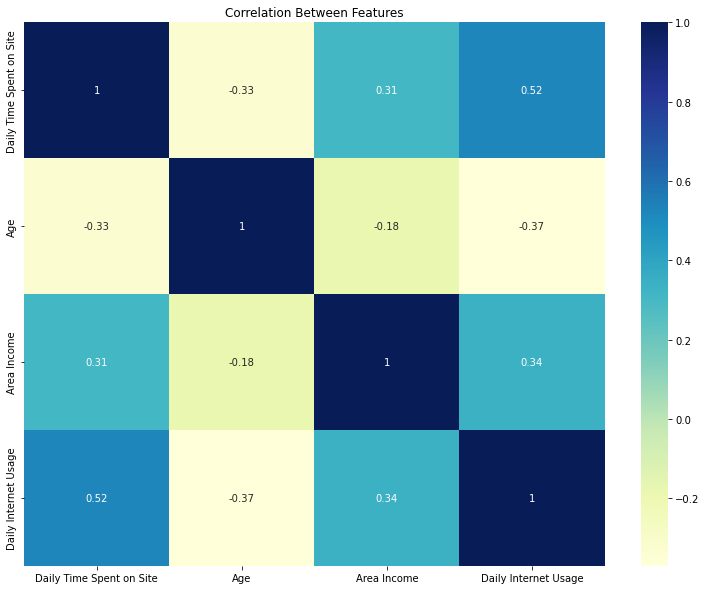

In [18]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")
plt.title('Correlation Between Features')
plt.show()

We discover no multicorrelation (correlation between variables) in the correlation above, so we may utilize all characteristics for modeling. However, Pearson correlation cannot tell us anything about the link between the feature and the target. So, in the following section, we will calculate the link between features and their targets using **PPS (Predictive Power Score)**.

### Correlation Using PPScore

In [19]:
df_pps = pps.matrix(df)
matrix_df = df_pps[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

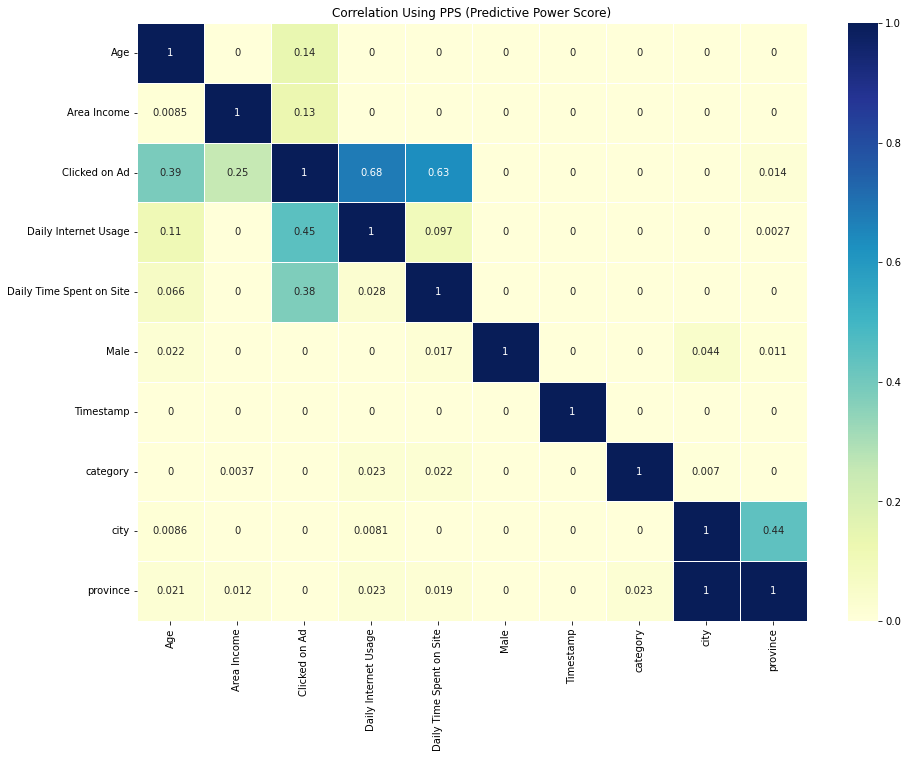

In [20]:
plt.figure(figsize=(15,11))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="YlGnBu", linewidths=0.5, annot=True)
plt.title('Correlation Using PPS (Predictive Power Score)')
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Based on the correlation plot created with PPS, we will simply look at the 'Clicked on Ad' feature. Because that variable will be our objective.

The feature is quite related to the target:
- Daily Internet Usage
- Daily Time Spent on Site
- Age
- Area Income

This correlation plot can be used as a guide for modeling.

## Data Cleaning & Preprocessing

In the case of data preprocessing, clean data is required so that it can be applied to various machine learning models.

The steps that we must complete are as follows:
1. Handle Missing Value
2. Extract Datetime Data
3. Split Target and features
4. Create One-hot encoding for feature category

### Handle Missing Value

In [21]:
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].mean(),inplace=True)
df['Area Income'].fillna(df['Area Income'].mean(),inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].mean(),inplace=True)
df['Male'].fillna(df['Male'].mode()[0],inplace=True)

### Extract Datetime Data

In [22]:
df['day_of_week'] = df['Timestamp'].apply(extract_day_of_week)
df['day_of_month'] = df['Timestamp'].apply(extract_day_of_month)
df['month'] = df['Timestamp'].apply(extract_month)

df = df.drop(labels=['Timestamp'],axis=1)

In [23]:
counts = df.groupby(['day_of_week','Clicked on Ad'],as_index=False).size()

### Split Target and Features 

In [24]:
X = df.drop(labels=['Clicked on Ad'],axis=1)
y = np.where(df['Clicked on Ad']=='No',0,1)

### Get Dummies for All Categorical Features

In [25]:
X_dummy = pd.get_dummies(X)

## Data Modeling

The modeling stage follows, during which we will create a high-accuracy model. We'll utilize the 'accuracy' metrics because the target has a fair number of categories.

Here are the steps to perform modeling:
1. Splitting train and test dataset
2. Train using default data (Experiment 1)
3. Train using normalization (Experiment 2)

### Splitting Train and Test Dataset

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X_dummy,y,test_size = 0.3,stratify=y,random_state = 123)

In [27]:
print('Dimensi Train:',X_train.shape)
print('Dimensi Test:',X_test.shape)

Dimensi Train: (700, 65)
Dimensi Test: (300, 65)


### Experiment 1

In [28]:
result = experiment(X_train,X_test,y_train,y_test)
result = pd.DataFrame(result)

In [29]:
result

,model_name,model,accuracy,recall,precision,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.696667,0.640000,0.721805,0.000000
1,Logistic Regression,LogisticRegression(),0.500000,0.000000,0.000000,0.009273
2,Decision Tree,DecisionTreeClassifier(),0.943333,0.926667,0.958621,0.005041
3,Random Forest,"(DecisionTreeClassifier(max_features='auto', r...",0.950000,0.920000,0.978723,0.140706
4,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.933333,0.913333,0.951389,0.170225


The modeling results using the default data are shown below (simple preprocessing).
- According on the modeling findings, the decision tree classifier has the highest accuracy.
- Random forest is another high-accuracy approach.
- The accuracy of some models, such as logistic regression and k-nearest neighbor, is poor.

### Experiment 2

In [30]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

In [39]:
result2 = experiment(X_train_minmax,X_test_minmax,y_train,y_test)
result2 = pd.DataFrame(result2)
result2

,model_name,model,accuracy,recall,precision,duration
0,K-Nearest Neighbor,KNeighborsClassifier(),0.800000,0.740000,0.840909,0.000000
1,Logistic Regression,LogisticRegression(),0.940000,0.900000,0.978261,0.004522
2,Decision Tree,DecisionTreeClassifier(),0.930000,0.926667,0.932886,0.000000
3,Random Forest,"(DecisionTreeClassifier(max_features='auto', r...",0.946667,0.920000,0.971831,0.164986
4,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.930000,0.913333,0.944828,0.175177


We saw considerable gains in various models after applying the min max scaler, particularly in the k-nearest neighbor and logistic regression models. In reality, logistic regression is the second most accurate model after random forest.

Based on these methodologies, we will select random forest as the best model because it has the maximum accuracy. If there are computing limits, Logistic Regression can also be a good option.

### Evaluation

In [40]:
final_model = result2['model'][3]
y_pred = final_model.predict(X_test_minmax)

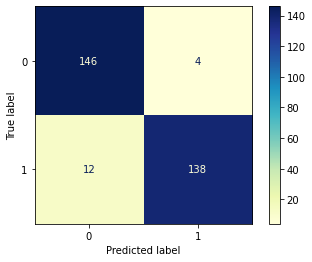

In [41]:
cm = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=final_model.classes_)

disp.plot(cmap='YlGnBu')
plt.show()

We want to see how our model performs in detail based on the random forest model. We shall use the confusion matrix for this. The random forest generated confusion matrix is excellent. We can see that the prediction mistakes (purple cells) are relatively small (top right and bottom left). With these results, we will have high accuracy, precision, and recall.

### Feature Importances

In [42]:
feature_imp = {}

feature_imp['columns'] = X_train.columns
feature_imp['feature_imp'] = result2['model'][3].feature_importances_

In [43]:
df_feature_imp = pd.DataFrame(feature_imp)
df_feature_imp = df_feature_imp.sort_values(['feature_imp'],ascending=False).head(20)

<AxesSubplot:xlabel='feature_imp', ylabel='columns'>

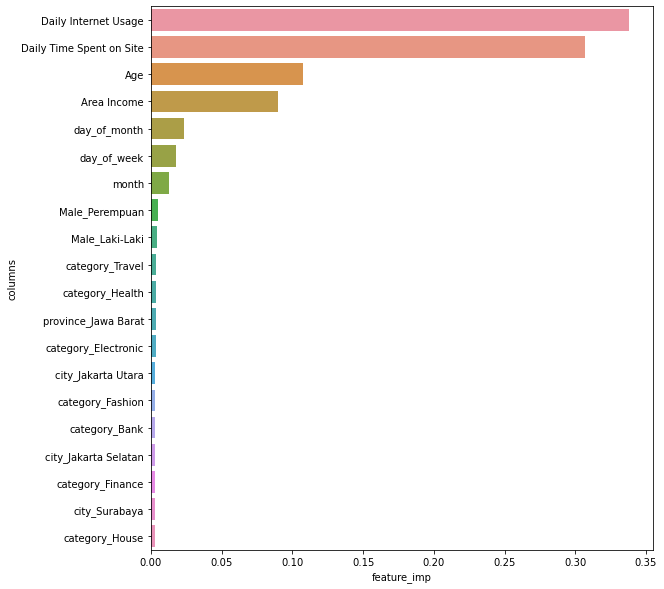

In [46]:
plt.figure(figsize=(9,10))
colors1 = ["#2B70E4", "#209D5C",'#FFD034']
customPalette1 = sns.set_palette(sns.color_palette(colors))
sns.barplot(x=df_feature_imp['feature_imp'],y=df_feature_imp['columns'],palette=customPalette1)

We can see the most essential elements in developing the model by using the random forest model.

According to the random forest approach, daily internet usage is a highly crucial factor in deciding whether a user will click or not. Other crucial factors include the amount of daily time spent on site, as well as the age and income of the community.

When we integrate the insights from the EDA process, we find that the more the daily internet usage, the lesser the likelihood that the user will click.

## Business Recomendation and Simulation

We can classify users into two categories based on EDA and feature importance: upper-class and lower-class users.

- The upper class meets the characteristics of regular internet use, frequent visits to a product website, being relatively youthful, and having a high sincome.
- The lower class has the opposite characteristics.

### Business Insight

- Users from lower socioeconomic levels are more likely to click on things in digital ads

- Users that use the internet frequently may find it more difficult to receive advertisements because they are accustomed to digital adverts.

- Parents represent a potentially lucrative market for the digital industry.

### Business Takeways

- We can use a more unique approach (soft selling) so that users are not as aware of the advertising.

- To attract low-end consumers, employ mainstream material (simple but relevant).

### Model Based - Simulation

Using the constructed ML model, we can run the following simulation:

Assuming:

- To advertise to a user, a budget of **10,000 rupiah** can be used.
- Test data can be used as a simulation tool for roughly 300 users, with 150 people in each class.
- We will make a profit of **12.000 rupiah** for each user that converts.

In [37]:
# Size of test data
X_test.shape

(300, 65)

In [38]:
# Number of classes in each data
jum_class = pd.Series(y_test).value_counts()
jum_class

1    150
0    150
dtype: int64

**Simulation Without Machine Learning** 
- We will use a budget of 10,000/user to do advertisement
- Cost : 300 x  10,000 = 3,000,000
- The conversion rate we will get is 50%
- There are 150 users who convert 
- Revenue : 150 x 12,000 = 1,800,000
- Profit : 1,800,000 - 3,000,000 = -1,200,000

According to the simulation above, if we do not apply the machine learning model, we will get a potential loss of Rp 1,200,000.-

<img src='https://drive.google.com/uc?id=1QqafiIgcQX2jyp8ua47-tssU-bapDUrL'>

**Simulation With Machine Learning** 
- We will only advertise to those who have potentially clicked (which we predict 1)
- We will use the same budget which is around 10,000/user to do advertisement
- Cost : 145 x 10,000 = 1,450.000
- We will get a conversion rate of 139/145 = 95.86%.
- We expect that 139 of the 145 users will convert.
- Revenue : 138 x 12,000 = 1,668,000
- Profit : 1,668,00 - 1,420,00 = 218,000

According to the simulation above, if we utilize the machine learning model, we may earn Rp 218,000.-

As a result, machine learning may work more efficiently and effectively, even converting potential losses into possible revenues.